In [ ]:
from google.colab import drive
drive.mount('/content/drive')

"from google.colab import drive\ndrive.mount('/content/drive')"

This is an ensemble model I constructed to process the new dataset.

This script contains data normalization and label encoding, XGBoost, feedforward neural network, and a logistic model.

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Redback_B/Heart_2022/heart_2022_no_nans.csv')

In [ ]:
df.shape # 40 variables

(246022, 40)

In [ ]:
df.info() # most are categorical variables

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246022 entries, 0 to 246021
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      246022 non-null  object 
 1   Sex                        246022 non-null  object 
 2   GeneralHealth              246022 non-null  object 
 3   PhysicalHealthDays         246022 non-null  float64
 4   MentalHealthDays           246022 non-null  float64
 5   LastCheckupTime            246022 non-null  object 
 6   PhysicalActivities         246022 non-null  object 
 7   SleepHours                 246022 non-null  float64
 8   RemovedTeeth               246022 non-null  object 
 9   HadHeartAttack             246022 non-null  object 
 10  HadAngina                  246022 non-null  object 
 11  HadStroke                  246022 non-null  object 
 12  HadAsthma                  246022 non-null  object 
 13  HadSkinCancer              24

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# separate features and labels
X = df.drop('HadHeartAttack', axis=1)
y = df['HadHeartAttack']

# split the data into training, validation, and test sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, stratify=y_val_test, random_state=42)

# Now I will use X_train, X_test, X_val and y_train, y_test, y_val

In [ ]:
object_columns = X_train.select_dtypes(include=['object']).columns.tolist()
print(object_columns)

['State', 'Sex', 'GeneralHealth', 'LastCheckupTime', 'PhysicalActivities', 'RemovedTeeth', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty', 'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus', 'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory', 'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos']


In [ ]:
numeric_columns = X_train.select_dtypes(include=['number']).columns.tolist()
print(numeric_columns)

['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms', 'BMI']


In [ ]:
# Use LabelEncoder to convert object columns
from sklearn.preprocessing import LabelEncoder

# Create LabelEncoder instance
label_encoder = LabelEncoder()

# Loop through object columns and apply label encoding
for column in object_columns:
    X_train[column] = label_encoder.fit_transform(X_train[column])
    X_test[column] = label_encoder.transform(X_test[column])
    X_val[column] = label_encoder.transform(X_val[column])


# Normalize numerical columns
scaler = StandardScaler()
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])
X_val[numeric_columns] = scaler.transform(X_val[numeric_columns])

In [ ]:
# Apply label encoding to target variables
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
y_val = label_encoder.transform(y_val)

In [ ]:
print(f'Shape of my datasets are: {X_train.shape}, {X_test.shape} and {X_val.shape}.')

Shape of my datasets are: (147613, 39), (49205, 39) and (49204, 39).


<ipython-input-19-7bf826b5bb94>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


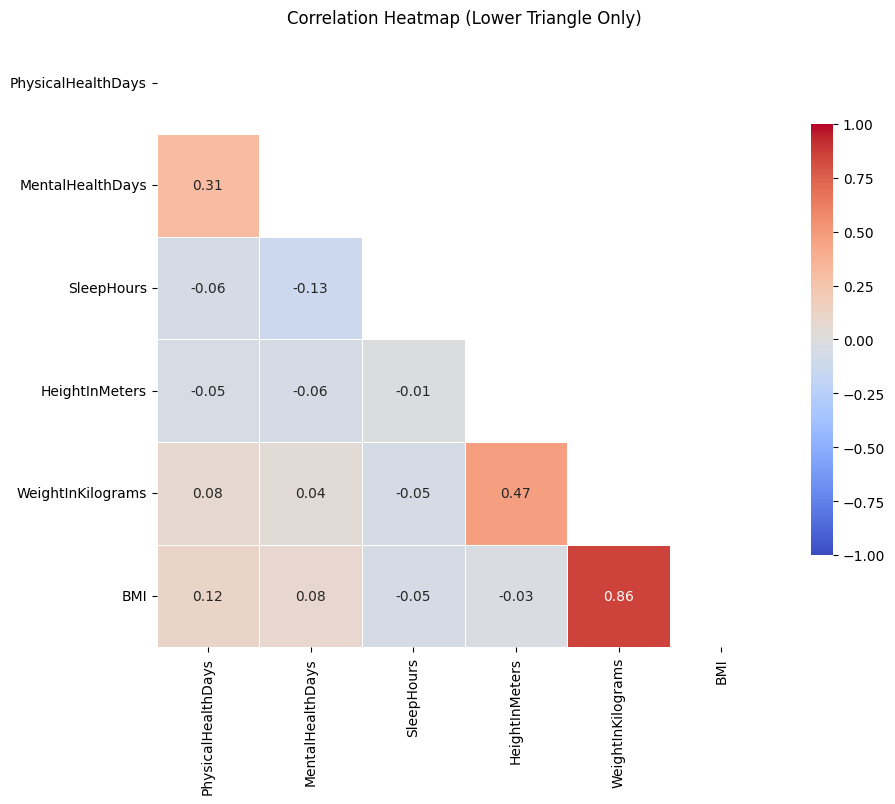

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix
corr_matrix = df.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", mask=mask,
            cmap='coolwarm', vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.7})

plt.title('Correlation Heatmap (Lower Triangle Only)')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import models, layers, optimizers, utils

# Set Python random seed
np.random.seed(42)
# Set TensorFlow random seed
tf.random.set_seed(42)

# Set input_shape as (39,) based on the number of features in X_train
input_shape = (39,)

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# XGBoost model
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_val)

# Feedforward Neural Network
fnn_model = MLPClassifier(hidden_layer_sizes=(100, 50)) # May adjust this parameter
fnn_model.fit(X_train, y_train)
fnn_predictions = fnn_model.predict(X_val)

# Combine predictions
combined_predictions = np.column_stack((xgb_predictions, fnn_predictions))

# Train a meta-model (e.g., Logistic Regression) on combined predictions
meta_model = LogisticRegression()
meta_model.fit(combined_predictions, y_val)

# Final predictions
xgb_test_predictions = xgb_model.predict(X_test)
fnn_test_predictions = fnn_model.predict(X_test)
combined_test_predictions = np.column_stack((xgb_test_predictions, fnn_test_predictions))
final_predictions = meta_model.predict(combined_test_predictions)

# Evaluate, the accuracy does not change much.
accuracy = accuracy_score(y_test, final_predictions)
print(f"Final Ensemble Model Accuracy: {accuracy}")


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Final Ensemble Model Accuracy: 0.9473224265826644


In [ ]:
combined_predictions

array([[0, 0],
       [0, 0],
       [0, 0],
       ...,
       [0, 0],
       [0, 0],
       [0, 0]])